# Friends 감정분석 with DNN
참고(링크) : https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html<br>
https://devtimes.com/nlp-korea-movie-review

# 준비
패키지, 파라미터 세팅

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from konlpy.tag import Okt
import nltk
from tqdm import tqdm
import time
import json
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

BATCH_SIZE = 512
NUM_EPOCHS = 20
TEST_SIZE = 0.2
RANDOM_SEED = 42

model_name = 'dnn_classifier_eng'

# 데이터 로드

In [3]:
def jsonToDf(file_name):
    with open(file_name, encoding = 'utf-8', mode = 'r') as file:
        json_array = json.load(file)
  
    result = pd.DataFrame.from_dict(json_array[0])

    is_first = True
    for array in json_array:
        if is_first:
            is_first = False
            continue
    
        temp_df = pd.DataFrame.from_dict(array)
        result = result.append(temp_df, ignore_index = True)

    return result

In [4]:
train_df = jsonToDf(DATA_IN_PATH+'friends_train.json')  # 학습용
dev_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 검증용
test_df = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터

In [5]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(10561, 4)
(1178, 4)
(1623, 5)


In [6]:
train_df.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [7]:
dev_df.head()

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,Chandler,Youre a genius!,joy,0500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100


In [8]:
test_df.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


# 데이터 탐색(EDA)

nltk 라이브러리의 Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공한다.vocab().most_common 매서드를 이용해 데이터가 가장 자주 사용되는 단어를 가져올 때 사용한다.

In [9]:
# Penn Treebank Tokenization 적용 예시
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
text = "Starting a home-based restaurant may be an ideal. it doesn't have a food chain or restaurant of their own."
print(tokenizer.tokenize(text))

['Starting', 'a', 'home-based', 'restaurant', 'may', 'be', 'an', 'ideal.', 'it', 'does', "n't", 'have', 'a', 'food', 'chain', 'or', 'restaurant', 'of', 'their', 'own', '.']


In [10]:
start = time.time()  # 시작 시간 저장

# 학습 데이터 tokenize
train_docs = []
for row in tqdm(train_df.values[:,1]):
    train_docs.append(tokenizer.tokenize(str(row)))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 10561/10561 [00:00<00:00, 21307.18it/s]

time : 0.497774600982666


In [11]:
print(train_docs[0])

['also', 'I', 'was', 'the', 'point', 'person', 'on', 'my', 'company\x92s', 'transition', 'from', 'the', 'KL-5', 'to', 'GR-6', 'system', '.']


In [12]:
# 학습데이터에서 분리된 토큰 개수 확인
tokens = [t for d in train_docs for t in d]
print("토큰개수:", len(tokens))

토큰개수: 105644


In [13]:
text = nltk.Text(tokens, name='FRIENDS')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

105644
7526
[(',', 7472), ('.', 5204), ('!', 4539), ('I', 3525), ('?', 3010), ('you', 2759), ('the', 1794), ('to', 1654), ('a', 1573), ('it', 1089)]


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


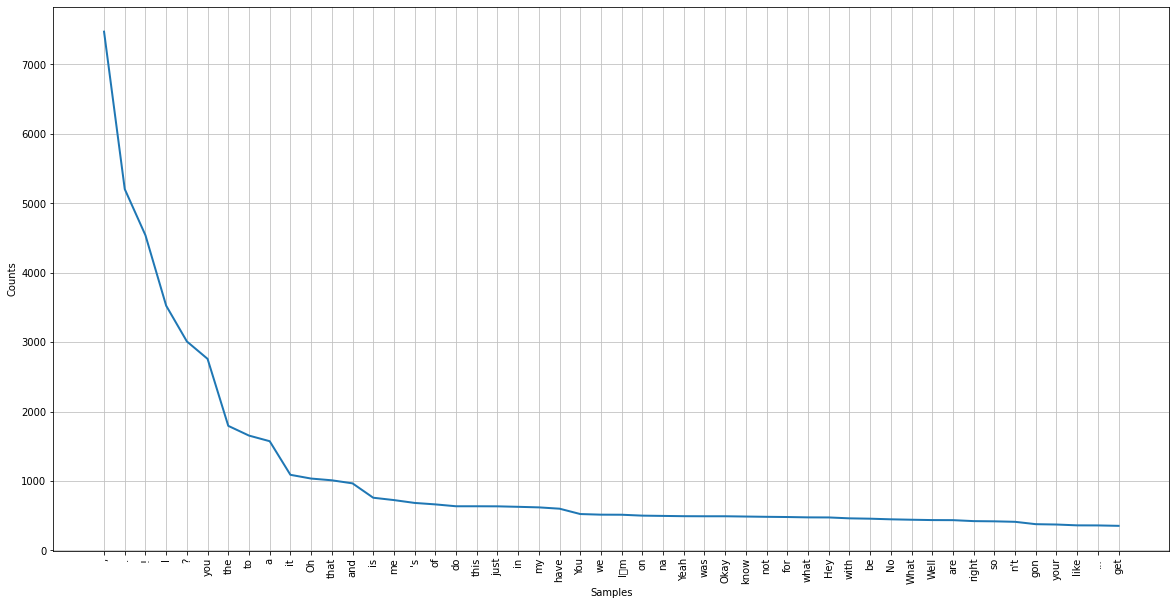

In [14]:
# 출력빈도가 높은 상위 토큰 10개를 matplotlib을 이용해 그래프로 확인
plt.figure(figsize=(20,10))
text.plot(50)

(-0.5, 799.5, 599.5, -0.5)

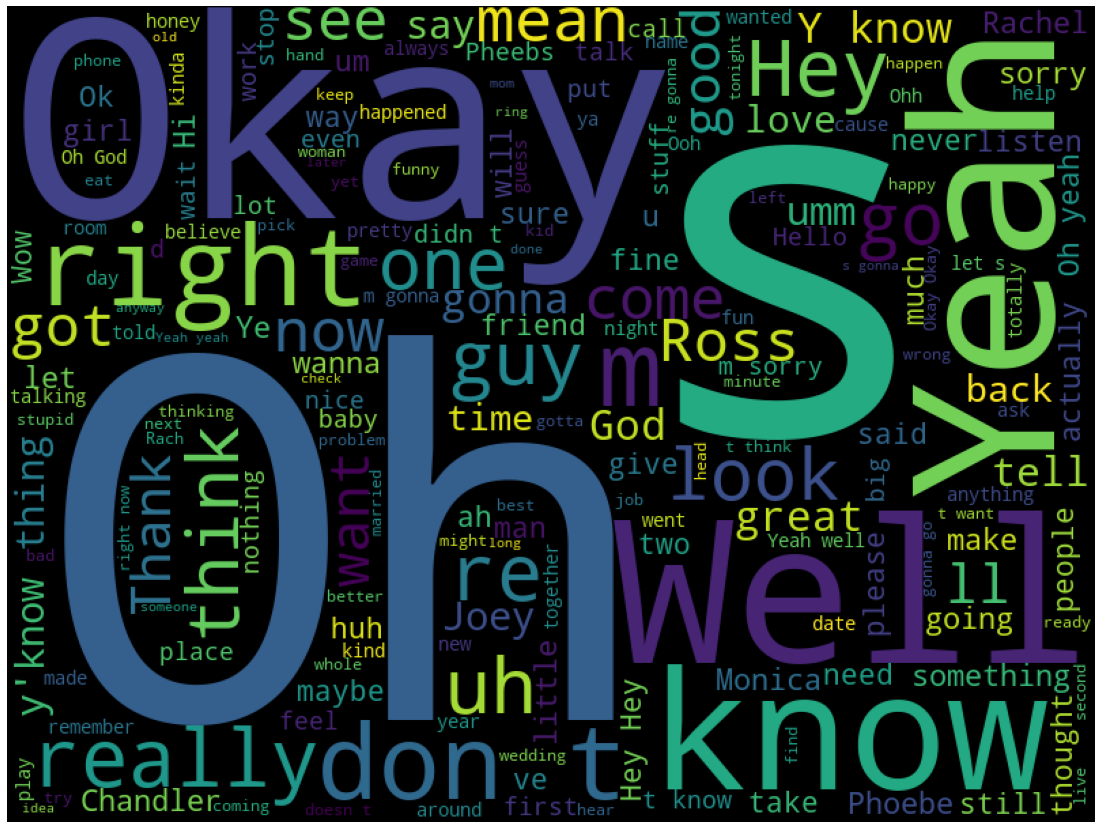

In [15]:
# 워드 클라우드 확인 (많이 사용된 단어)
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_df['utterance']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# 데이터 전처리

In [16]:
def data_cleansing(train_data, dev_data, test_data, con=0):  # 0: 전처리 없음(null값 공백 치환), 1: 숫자 제거, 2: 특수문자 제거
    global train_df
    global dev_df
    global test_df
    
    train_data = jsonToDf(DATA_IN_PATH+'friends_train.json')  # 학습용
    dev_data = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 검증용
    test_data = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터
   
    train_data.drop(['speaker','annotation'], axis=1, inplace=True)
    dev_data.drop(['speaker','annotation'], axis=1, inplace=True)
    test_data.drop(['i_dialog','i_utterance','speaker'], axis=1, inplace=True)

    train_df = train_data.copy()
    dev_df = dev_data.copy()
    test_df = test_data.copy()
    
    if con == 1:  # 숫자 제거 & Null 치환(공백), row 제거 없음
        # 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미)
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        
    elif con == 2:  # 특수문자 제거 & Null 치환(공백), row 제거 없음
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        
    else:
        train_df = train_df.fillna(' ')
        dev_df = dev_df.fillna(' ')
        test_df = test_df.fillna(' ')
    
    print('전처리 후 학습 데이터 :',train_df.shape)
    print('전처리 후 검증 데이터 :',dev_df.shape)
    print('전처리 후 테스트 데이터 :',test_df.shape)


In [17]:
# 데이터 전처리 선택
data_cleansing(train_df, dev_df, test_df, con=2)  # 0: 전처리 없음(null값 공백 치환), 1: 특수문자 제거, 2: 영어이외 제거

전처리 후 학습 데이터 : (10561, 2)
전처리 후 검증 데이터 : (1178, 2)
전처리 후 테스트 데이터 : (1623, 2)


In [18]:
train_df.head()

,utterance,emotion
0,also I was the point person on my companys tra...,neutral
1,You mustve had your hands full,neutral
2,That I did That I did,neutral
3,So lets talk a little bit about your duties,neutral
4,My duties All right,surprise


In [19]:
dev_df.head()

,utterance,emotion
0,Oh my God hes lost it Hes totally lost it,non-neutral
1,What,surprise
2,Or Or we could go to the bank close our accoun...,neutral
3,Youre a genius,joy
4,Aww man now we wont be bank buddies,sadness


In [20]:
test_df.head()

,id,utterance
0,0,Alright whadyou do with him
1,1,Oh Youre awake
2,2,Then you gotta come clean with Ma This is not ...
3,3,Yeah but this is
4,4,I dont wanna hear it Now go to my room


In [21]:
print(train_df.dtypes,'\n')
print(dev_df.dtypes,'\n')
print(test_df.dtypes)

utterance    object
emotion      object
dtype: object 

utterance    object
emotion      object
dtype: object 

id            int64
utterance    object
dtype: object


# TF-IDF를 활용한 벡터화

Bag of Words 모델은 문서가 가지는 모든 단어를 문맥이나 순서를 무시하고 일괄적으로 단어에 대해 빈도 값을 부여해 피처 값을 추출하는 모델이다. 문서 내 모든 단어를 한꺼번에 봉투(bag) 안에 넣은 뒤에 흔들어서 섞는다는 의미로 Bag of Words(BOW) 모델이라고 한다.<br>

머신러닝 알고리즘은 일반적으로 숫자형 피처를 데이터로 입력받아 동작하기 때문에 텍스트 데이터는 머신러닝 알고리즘에 바로 입력할 수 없다. 따라서 텍스트는 특정 의미를 가지는 숫자형 값인 벡터 값으로 변환해야 하고, 이러한 변환을 피처 벡터화라고 한다. 일반적으로 BOW의 피처 벡터화는 (1) 카운트 벡터화, (2) TF-IDF 벡터화 두 가지 방식이 있다.

사이킷런의 CountVertorizer, TfidfVectorizer를 이용해 텍스트를 피처 단위로 벡터화해 변환하고 CSR 형태의 희소 행렬을 반환한다. 단순하게 피처 벡터화만 수행하는게 아니라 소문자 일괄 변환, 토큰화, 스톱 워드 필터링 등의 텍스트 전처리도 함께 수행할 수 있다.

벡터화의 결과는 대부분의 값이 0을 가지는 희소 행렬이며 메모리 공간을 효율적으로 사용하기 위한 CSR(Compressed Sparse Row) 형태이다. CountVertorizer, TfidfVectorize를 적용할 때는 반드시 학습 데이터를 이용해 fit()이 수행된 객체를 통해 테스트 데이터를 변환(transform)해야 한다. 그래야만 학습 시 사용된 피처 개수와 예측 시 사용할 피처 개수를 동일하게 맞출 수 있다.

일반적으로 문서 내에 텍스트가 많고 많은 문서를 가지는 텍스트 분석에서는 카운트 벡터화보다 TF-IDF 벡터화가 좋은 예측 결과를 도출한다.

In [22]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

start = time.time()  # 시작 시간 저장

# TfidfVectorizer를 이용해 학습 데이터를 TF-IDF 값으로 피처 변환
# TfidfVectorizer 클래스의 스톱 워드를 'english'로, ngram_range는 (1, 2), max_df=700으로 설정한다.
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=700)
vectorizer.fit(train_df['utterance'])
train_data_features = vectorizer.transform(train_df['utterance'])

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 검증 데이터를 TF-IDF 값으로 피처 변환
dev_data_features = vectorizer.transform(dev_df['utterance'])

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환
test_data_features = vectorizer.transform(test_df['utterance'])

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
print()
print(train_data_features.shape)
print(dev_data_features.shape)
print(test_data_features.shape)
print(type(train_data_features))

time : 0.2307724952697754

(10561, 27535)
(1178, 27535)
(1623, 27535)
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
# DNN 모델에 입력으로 넣기 위한 numpy array 처리
train_data_array = train_data_features.toarray()
print(type(train_data_array), train_data_array.shape)

dev_data_array = dev_data_features.toarray()
print(type(dev_data_array), dev_data_array.shape)

test_data_array = test_data_features.toarray()
print(type(test_data_array), test_data_array.shape)

# # 참고
# tfidf_mat = vectorizer.fit_transform(train_df['utterance']).toarray()
# print(type(tfidf_mat),tfidf_mat.shape)
# # <class 'numpy.ndarray'> (11739, 27407)

<class 'numpy.ndarray'> (10561, 27535)
<class 'numpy.ndarray'> (1178, 27535)
<class 'numpy.ndarray'> (1623, 27535)


In [24]:
# Friends 감정 딕셔너리 생성
emoset = {'non-neutral': 0,
          'neutral': 1, 
          'joy': 2,
          'sadness': 3,
          'fear': 4,
          'anger': 5,
          'surprise': 6,
          'disgust': 7}

In [25]:
# 'label' 컬럼 신규
#for emo in train_df['emotion'][:10]:  print(emo, emoset[emo])
train_df['label'] = [emoset[emo] for emo in train_df['emotion']]
dev_df['label'] = [emoset[emo] for emo in dev_df['emotion']]

In [26]:
# 학습, 검증(Origianl Testset) 데이터 레이블 넘파이 배열 처리
y_train = np.array(train_df['label'])
y_dev = np.array(dev_df['label'])

In [27]:
y_train

array([1, 1, 1, ..., 6, 1, 0])

In [28]:
print(y_train.shape)
print(y_dev.shape)

(10561,)
(1178,)


# 모델 생성 & 학습
텐서플로 케라스를 이용해 모델을 만들어 본다. 레이어 구성은 두개의 Dense층은 64개의 유닛을 가지고 활성함수는 relu를 사용하고, 마지막층은 softmax 활성화 함수를 사용해 다중 클래스 분류 확률을 출력한다.

In [29]:
FREQUENCY_COUNT = train_data_array.shape[1]  # 27535

In [30]:
# 레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    # 클래스별 확률값을 출력하기 위해 8개의 뉴런과 softmax 활성화 함수를 사용
    tf.keras.layers.Dense(8, activation='softmax')
])

In [31]:
from keras import optimizers

# 학습 프로세스 설정 (sparse_categorical_crossentropy 기반)
model.compile(
            optimizer=optimizers.RMSprop(lr=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

# optimizer='sgd'
# optimizer='rmsprop'
# optimizer='adam'
# optimizer=optimizers.RMSprop(lr=0.001)

검증 정확도를 통한 EarlyStopping 기능과 모델 저장 방식을 지정하고,
모델을 검증하기 위한 검증 데이터도 model.fit 안에 있는 validation_split로 지정한 다음 학습을 시작한다.

In [32]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights_dnn_friends.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/dnn_classifier_eng -- Folder already exists 



In [33]:
history = model.fit(train_data_array, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=TEST_SIZE, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.9875 - sparse_categorical_accuracy: 0.4260
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.44676, saving model to ./data_out/dnn_classifier_eng/weights_dnn_friends.h5
17/17 [==============================] - 23s 1s/step - loss: 1.9875 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.8541 - val_sparse_categorical_accuracy: 0.4468
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.7169 - sparse_categorical_accuracy: 0.4508
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.44676
17/17 [==============================] - 20s 1s/step - loss: 1.7169 - sparse_categorical_accuracy: 0.4508 - val_loss: 1.6278 - val_sparse_categorical_accuracy: 0.4468
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5255 - sparse_categorical_accuracy: 0.4518
Epoch 00003: val_sparse_categorical_accuracy improved from 0.44676 to 0.45102, saving model to ./data_out/dn

In [34]:
train_preds = model.predict(train_data_array)

preds = []
for i, pred in enumerate(train_preds):
    result = np.argmax(pred)
    preds.append(result)

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train, preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.70175


In [36]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.69      0.69      0.69      2017
     neutral       0.73      0.95      0.82      4752
         joy       0.80      0.67      0.73      1283
     sadness       1.00      0.04      0.08       351
        fear       0.00      0.00      0.00       185
       anger       0.85      0.37      0.51       513
    surprise       0.79      0.62      0.69      1220
     disgust       1.00      0.07      0.12       240

    accuracy                           0.73     10561
   macro avg       0.73      0.43      0.46     10561
weighted avg       0.74      0.73      0.70     10561



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Loss, Accuracy 시각화 함수 1
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

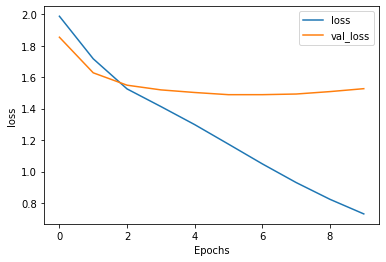

In [38]:
plot_graphs(history, 'loss')

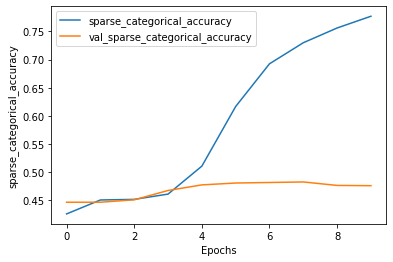

In [39]:
plot_graphs(history, 'sparse_categorical_accuracy')

In [40]:
# Loss, Accuracy 시각화 함수 2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

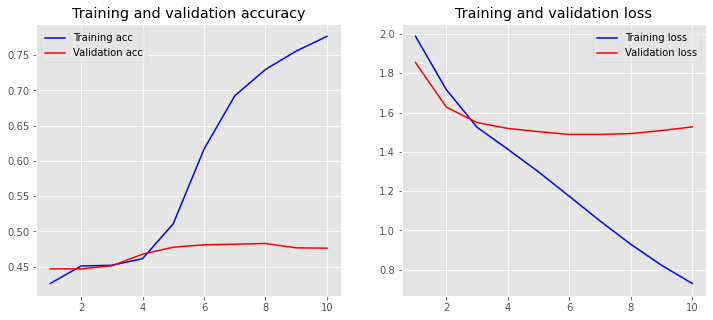

In [41]:
plot_history(history)

# 모델 평가 - 검증 데이터셋(Original Test Dataset)
테스트 데이터를 통해 모델을 평가

In [42]:
SAVE_FILE_NM = 'weights_dnn_friends.h5' #저장된 best model 이름
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [43]:
results = model.evaluate(dev_data_array, y_dev)

37/37 [==============================] - 0s 2ms/step - loss: 1.6656 - sparse_categorical_accuracy: 0.4219


In [44]:
# optimizer='sgd' => loss: 1.6905888319015503, acc: 0.4703328609466553
# optimizer='rmsprop' => loss: 2.4182658195495605, acc: 0.4489869773387909
# optimizer='adam' => loss: 2.8616557121276855, acc: 0.4337916076183319
results

[1.665602207183838, 0.42190152406692505]

In [45]:
dev_preds = model.predict(dev_data_array)

preds = []
for i, pred in enumerate(dev_preds):
    result = np.argmax(pred)
    preds.append(result)

In [46]:
from sklearn.metrics import f1_score
f1 = f1_score(y_dev, preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.34350


In [47]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_dev, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.18      0.15      0.16       214
     neutral       0.47      0.84      0.60       491
         joy       0.47      0.21      0.29       123
     sadness       0.00      0.00      0.00        62
        fear       0.00      0.00      0.00        29
       anger       0.00      0.00      0.00        85
    surprise       0.39      0.19      0.25       151
     disgust       0.00      0.00      0.00        23

    accuracy                           0.42      1178
   macro avg       0.19      0.17      0.16      1178
weighted avg       0.33      0.42      0.34      1178



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (참고) 제출 파일 생성

In [48]:
preds = model.predict(test_data_array)

In [49]:
start = time.time()

test_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time : ", time.time() - start)

0번 인덱스 데이터 처리 완료 => [0.02038621 0.9338626  0.0145403  0.00450668 0.00212523 0.01520358
 0.00737001 0.00200546] 1
1번 인덱스 데이터 처리 완료 => [0.2124076  0.15446377 0.24813592 0.04345009 0.02569618 0.05741863
 0.21753578 0.04089196] 2
2번 인덱스 데이터 처리 완료 => [0.27898094 0.3652478  0.06686028 0.0375544  0.0232331  0.08557583
 0.11781392 0.02473374] 1
3번 인덱스 데이터 처리 완료 => [0.0756705  0.71968985 0.11805068 0.01162943 0.00473498 0.02209257
 0.04171216 0.00641978] 1
4번 인덱스 데이터 처리 완료 => [0.19710758 0.57512075 0.06774315 0.02101671 0.01155636 0.04633749
 0.06835486 0.01276311] 1
5번 인덱스 데이터 처리 완료 => [0.13452025 0.56666553 0.05311995 0.04266378 0.02430824 0.10354063
 0.05155754 0.02362413] 1
6번 인덱스 데이터 처리 완료 => [0.14767392 0.66714495 0.06722189 0.01762068 0.00772839 0.04038431
 0.04295054 0.00927533] 1
7번 인덱스 데이터 처리 완료 => [0.31260753 0.32355067 0.11440746 0.04134128 0.02139694 0.05707525
 0.10239904 0.02722179] 1
8번 인덱스 데이터 처리 완료 => [0.24681045 0.34919584 0.09628306 0.03647699 0.02021865 0.06743506
 0.157380

 0.09673066 0.03128918] 1
518번 인덱스 데이터 처리 완료 => [0.16893278 0.02559242 0.04149008 0.0122353  0.00613989 0.01914682
 0.7149787  0.01148392] 6
519번 인덱스 데이터 처리 완료 => [0.1848403  0.3527071  0.14804597 0.04497999 0.02672822 0.07511674
 0.13329825 0.03428344] 1
520번 인덱스 데이터 처리 완료 => [0.16856006 0.68793195 0.06487874 0.01022747 0.00381428 0.01923954
 0.0404759  0.00487205] 1
521번 인덱스 데이터 처리 완료 => [0.06818602 0.81423396 0.04835133 0.00799278 0.00336823 0.01924312
 0.03461962 0.00400496] 1
522번 인덱스 데이터 처리 완료 => [0.06124602 0.8711516  0.0171534  0.0061771  0.00289666 0.02324488
 0.01534001 0.00279033] 1
523번 인덱스 데이터 처리 완료 => [0.0756705  0.71968985 0.11805068 0.01162943 0.00473498 0.02209257
 0.04171216 0.00641978] 1
524번 인덱스 데이터 처리 완료 => [0.11570711 0.7484565  0.04517822 0.01291889 0.00607107 0.03153094
 0.03371852 0.0064188 ] 1
525번 인덱스 데이터 처리 완료 => [0.28451636 0.21220548 0.22600074 0.0417393  0.0221364  0.05586934
 0.12231376 0.03521854] 0
526번 인덱스 데이터 처리 완료 => [0.09692023 0.69626653 0.0731341

 0.03066705 0.00533385] 1
1039번 인덱스 데이터 처리 완료 => [0.09014303 0.6636491  0.12264977 0.01954099 0.00920009 0.0385222
 0.04456896 0.01172594] 1
1040번 인덱스 데이터 처리 완료 => [0.05283683 0.83743525 0.06065441 0.00578287 0.00227129 0.01213729
 0.02615451 0.00272754] 1
1041번 인덱스 데이터 처리 완료 => [0.1848403  0.3527071  0.14804597 0.04497999 0.02672822 0.07511674
 0.13329825 0.03428344] 1
1042번 인덱스 데이터 처리 완료 => [0.11584033 0.592584   0.09818654 0.02589453 0.01374826 0.05145094
 0.08673207 0.01556332] 1
1043번 인덱스 데이터 처리 완료 => [0.06322068 0.8504649  0.03774026 0.00694746 0.00310203 0.01850317
 0.01667944 0.00334207] 1
1044번 인덱스 데이터 처리 완료 => [0.18674845 0.5793848  0.1307712  0.0160899  0.00661236 0.02742342
 0.04365305 0.00931682] 1
1045번 인덱스 데이터 처리 완료 => [0.20298369 0.4446347  0.07668278 0.02420384 0.0132594  0.05764775
 0.16595832 0.01462948] 1
1046번 인덱스 데이터 처리 완료 => [0.1848403  0.3527071  0.14804597 0.04497999 0.02672822 0.07511674
 0.13329825 0.03428344] 1
1047번 인덱스 데이터 처리 완료 => [0.40883183 0.2751907  0

1521번 인덱스 데이터 처리 완료 => [0.12811898 0.49696246 0.19062598 0.0248939  0.01218538 0.04391493
 0.08563014 0.01766825] 1
1522번 인덱스 데이터 처리 완료 => [0.4855556  0.11890373 0.03648799 0.03715675 0.01968758 0.06391107
 0.21609914 0.02219809] 0
1523번 인덱스 데이터 처리 완료 => [0.22734535 0.16787429 0.10579637 0.12587471 0.06424378 0.10881859
 0.13119362 0.06885326] 0
1524번 인덱스 데이터 처리 완료 => [0.32939973 0.22669943 0.05369824 0.01820019 0.00863122 0.03427278
 0.31822324 0.01087525] 0
1525번 인덱스 데이터 처리 완료 => [0.11210274 0.72468144 0.04383749 0.01301592 0.00661532 0.03602669
 0.0571999  0.00652053] 1
1526번 인덱스 데이터 처리 완료 => [0.1848403  0.3527071  0.14804597 0.04497999 0.02672822 0.07511674
 0.13329825 0.03428344] 1
1527번 인덱스 데이터 처리 완료 => [0.05132747 0.8545606  0.03729231 0.00749319 0.00350994 0.02250032
 0.01975194 0.00356422] 1
1528번 인덱스 데이터 처리 완료 => [0.2970868  0.24830846 0.05349888 0.05426763 0.04102466 0.14322957
 0.12128686 0.0412971 ] 0
1529번 인덱스 데이터 처리 완료 => [0.23535608 0.07039711 0.0686869  0.0265988  0.01

In [50]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

# 테스트 데이터의 id, 리뷰 부분을 리스트 처리
ids = list(test_df['id'])
test_utterances = list(test_df['utterance'])

# 숫자로 인코딩 된 레이블을 감정명으로 재매칭
emo_preds = [emoset_reverse[label] for label in test_preds]

# 판다스 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": ids, "Predicted": emo_preds} )
output.head()

,Id,Predicted
0,0,neutral
1,1,joy
2,2,neutral
3,3,neutral
4,4,neutral


In [51]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + "FRIENDS_DNN.csv", index = False)  # 앙상블 조합 및 캐글 용도

### 캐글 제출 결과
**[2020.12.20]**<br>
0.41553

# (참고) 입력 문장 감정/확률 예측하기
문자열을 받아 바로 결과를 예측하는 함수를 만들어 본다.

In [42]:
# review = "That's too funny!"
# print(tokenizer.tokenize(review))

In [43]:
# emo_pres = dict(zip(emoset.values(),emoset.keys()))
# emo_pres

In [106]:
# 입력을 리스트 형태로 넣어야 함
# 참고 : https://m.blog.naver.com/PostView.nhn?blogId=samsjang&logNo=220985170721&proxyReferer=https:%2F%2Fwww.google.com%2F
def sentiment_predict(new_sentence):
    emo_pres = dict(zip(emoset.values(),emoset.keys()))
    new_sentence = vectorizer.transform(new_sentence)  # TF-IDF 값으로 피처 변환
    preds = model.predict(new_sentence)
    print('예측: %s\n확률: %.3f%%' %(emo_pres[np.argmax(preds[0])], \
                                 #np.max(model.predict_proba(new_sentence))*100))
                                 np.max(model.predict(new_sentence))*100))

In [107]:
# preds = model.predict(vectorizer.transform(['how do you know?']))
# test_preds = []
# result = np.argmax(preds[0])
# test_preds.append(result)
# emo_pres[test_preds[0]]

In [108]:
sentiment_predict(['how do you know?'])

예측: neutral
확률: 50.004%


In [109]:
sentiment_predict(['I love you!'])

예측: joy
확률: 78.419%


In [110]:
sentiment_predict(['I hate that!'])

예측: anger
확률: 29.227%
